### Prior and Posterior
$$A \sim \cal{N}(0,s I)$$
$$q(A) =\cal{N}(\mu_A, \Lambda_A)$$

### Likelihood
$$Y|A,X = Y|\prod_c A_c^T X_c$$

In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
tf.logging.set_verbosity(tf.logging.ERROR)
np.random.seed(10)

## Simulating synthetic data

In [2]:
#lik = 'Poisson'
lik = 'Gaussian'
assert lik in ['Poisson','Gaussian']

#---------------------------------------------------
# Declaring additive model parameters
N =1000
D = 20 # number of covariates 
R = 1 # number of trials
A = np.random.randn(D,1)

indices = [np.arange(0,int(D/3)).tolist(), 
           np.arange(int(D/3),int(2*D/3)).tolist(), 
           np.arange(int(2*D/3),D).tolist()]
print(indices)
#---------------------------------------------------
# Simulating data
np_link,tf_link = np.exp, tf.exp

xmin,xmax=-1,1
X_np = np.random.uniform(xmin,xmax,(N,D))

A_tile = np.tile(np.expand_dims(A,0),[N,1,R])
X_tile = np.tile(np.expand_dims(X_np,-1),[1,1,R])
proj_np = X_tile*A_tile
pred_np = proj_np[:,indices[0],:].sum(axis=1) 
for i in range(1,len(indices)):
    pred_np *= proj_np[:,indices[i],:].sum(axis=1) 

if lik == 'Gaussian':
    Y_np = pred_np + np.random.rand(N,R)*.1
elif lik=='Poisson':
    link = np.exp
    rate = np.tile(link(pred_np),[1,R])
    Y_np = np.random.poisson(rate,size=(N,R))
    
print(A.shape)
print(proj_np.shape,pred_np.shape,Y_np.shape)

[[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12], [13, 14, 15, 16, 17, 18, 19]]
(20, 1)
(1000, 20, 1) (1000, 1) (1000, 1)


## Constructing tensorflow model

In [3]:
import sys
sys.path.append('../MFVI')
from likelihoods import Gaussian, Poisson, Gaussian_with_link
from settings import np_float_type,int_type
from model import MFVI, MFVI2

#---------------------------------------------------
# Constructing tensorflow model

X = tf.placeholder(tf.float32,[N,D])
Y = tf.placeholder(tf.float32,[N,R])


with tf.variable_scope("likelihood") as scope:
    if lik=='Gaussian':
        likelihood = Gaussian(variance=1)
    elif lik == 'Poisson':
        likelihood = Poisson()

with tf.variable_scope("model") as scope:
    m= MFVI2(X,Y,likelihood,indices=indices)

    
vars_opt = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/inference')
vars_opt += tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='likelihood')

## Running inference and learning

In [5]:

#---------------------------------------------------

sess  = tf.Session()
sess.run(tf.global_variables_initializer()) # reset values to wrong
# declare loss
loss = -m.build_likelihood()
opt_global = tf.train.AdamOptimizer(1e-2).minimize(loss,var_list=vars_opt)
init = tf.global_variables_initializer()
sess.run(init) # reset values to wrong
feed_dic = {Y:Y_np, X:X_np}

#---------------------------------------------------


print('Running Optimization...')
nit = 5000
loss_array = np.zeros((nit,))

for it in tqdm(range( nit)):
    sess.run(opt_global,feed_dict=feed_dic)
    loss_array[it]= float(sess.run(loss, feed_dic))

    #if it%1000==0:
    #    print( 'iteration %d'%it)
    #    print( sess.run(m.s))
    #    print( sess.run(m.q_A_sqrt).T)
        
        
p_mean = sess.run(tf.reduce_mean(m.sample_predictor(X),-1),  feed_dic)
q_A_mu = sess.run(m.q_A_mu,  feed_dic)
q_A_sqrt = sess.run(m.q_A_sqrt,  feed_dic)

sess.close()

print('Done')


  0%|          | 3/5000 [00:00<03:03, 27.24it/s]

Running Optimization...


100%|██████████| 5000/5000 [01:57<00:00, 42.70it/s]


Done


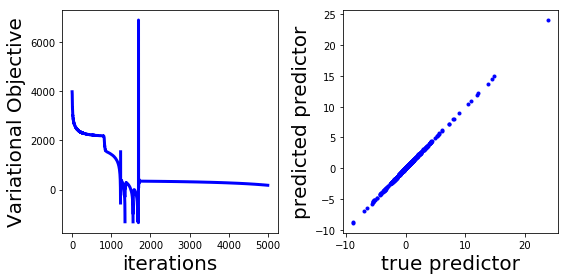

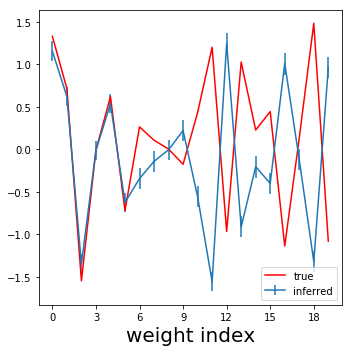

In [11]:
fig,axarr = plt.subplots(1,2,figsize=(8,4))
ax=axarr[0]
ax.plot(loss_array[:it], linewidth=3, color='blue')
ax.set_xlabel('iterations',fontsize=20)
ax.set_ylabel('Variational Objective',fontsize=20)
ax=axarr[1]
ax.plot(pred_np, p_mean,'.', color='blue')
ax.set_xlabel('true predictor',fontsize=20)
ax.set_ylabel('predicted predictor',fontsize=20)

fig.tight_layout()
plt.show()
plt.close()


fig,ax = plt.subplots(1,figsize=(5,5))
ax.plot(A,'r',label='true')
ax.errorbar(range(D),y=q_A_mu[:,0],yerr=q_A_sqrt[:,0],label='inferred')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_xlabel('weight index',fontsize=20)
ax.set_xticks(np.arange(0,D,3))
ax.set_xticklabels(np.arange(0,D,3))
fig.tight_layout()

plt.show()
